<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-CIFAR-10-데이터셋-준비하기" data-toc-modified-id="1.-CIFAR-10-데이터셋-준비하기-1">1. CIFAR-10 데이터셋 준비하기</a></span><ul class="toc-item"><li><span><a href="#1)-CIFAR-10-데이터셋-로드" data-toc-modified-id="1)-CIFAR-10-데이터셋-로드-1.1">1) CIFAR-10 데이터셋 로드</a></span></li><li><span><a href="#2)-Input-Normalization" data-toc-modified-id="2)-Input-Normalization-1.2">2) Input Normalization</a></span></li></ul></li><li><span><a href="#2.-VGG-기본-블록-구성하기" data-toc-modified-id="2.-VGG-기본-블록-구성하기-2">2. VGG 기본 블록 구성하기</a></span></li><li><span><a href="#3.-VGG-Complete-Model" data-toc-modified-id="3.-VGG-Complete-Model-3">3. VGG Complete Model</a></span><ul class="toc-item"><li><span><a href="#1)-VGG-16" data-toc-modified-id="1)-VGG-16-3.1">1) VGG-16</a></span></li><li><span><a href="#2)-VGG-19" data-toc-modified-id="2)-VGG-19-3.2">2) VGG-19</a></span></li></ul></li><li><span><a href="#4.-VGG-16과-VGG-19-성능-비교" data-toc-modified-id="4.-VGG-16과-VGG-19-성능-비교-4">4. VGG-16과 VGG-19 성능 비교</a></span></li></ul></div>

# 1. CIFAR-10 데이터셋 준비하기
## 1) CIFAR-10 데이터셋 로드

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


## 2) Input Normalization

In [6]:
# 255로 나누어 0~1 사이의 값으로 정규화
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

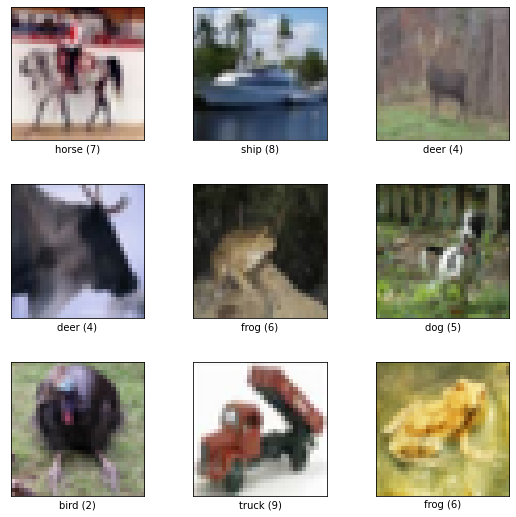

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

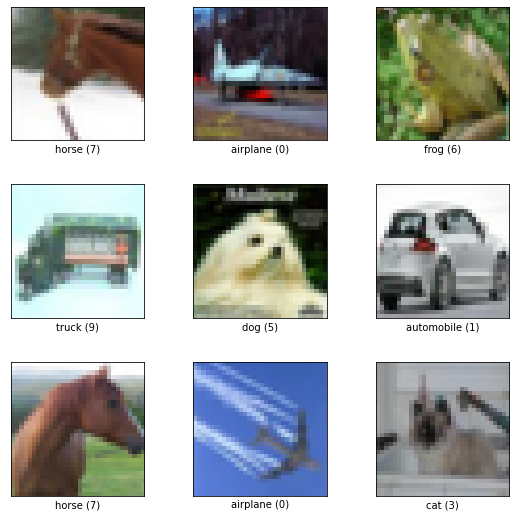

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

# 2. VGG 기본 블록 구성하기

In [12]:
# function for building VGG Block
def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,  # 레이어에 이름을 붙이기 위해 추가
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))  # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [14]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


# 3. VGG Complete Model
## 1) VGG-16

In [15]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [16]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## 2) VGG-19

In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

# 4. VGG-16과 VGG-19 성능 비교

In [18]:
BATCH_SIZE = 256
EPOCH = 40

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [20]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
195/195 [==============================] - 32s 163ms/step - loss: 2.1842 - accuracy: 0.1934 - val_loss: 2.0797 - val_accuracy: 0.2507
Epoch 2/40
195/195 [==============================] - 54s 277ms/step - loss: 1.9887 - accuracy: 0.2795 - val_loss: 1.9008 - val_accuracy: 0.3284
Epoch 3/40
195/195 [==============================] - 17s 86ms/step - loss: 1.8674 - accuracy: 0.3293 - val_loss: 1.8397 - val_accuracy: 0.3476
Epoch 4/40
195/195 [==============================] - 17s 86ms/step - loss: 1.7646 - accuracy: 0.3666 - val_loss: 1.7074 - val_accuracy: 0.3945
Epoch 5/40
195/195 [==============================] - 17s 86ms/step - loss: 1.6783 - accuracy: 0.3956 - val_loss: 1.6368 - val_accuracy: 0.4099
Epoch 6/40
195/195 [==============================] - 17s 86ms/step - loss: 1.6145 - accuracy: 0.4151 - val_loss: 1.5977 - val_accuracy: 0.4343
Epoch 7/40
195/195 [==============================] - 17s 85ms/step - loss: 1.5571 - accuracy: 0.4380 - val_loss: 1.5142 - val_accurac

In [21]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
195/195 [==============================] - 19s 99ms/step - loss: 2.2062 - accuracy: 0.1781 - val_loss: 2.0997 - val_accuracy: 0.2527
Epoch 2/40
195/195 [==============================] - 19s 99ms/step - loss: 2.0151 - accuracy: 0.2631 - val_loss: 1.9152 - val_accuracy: 0.3084
Epoch 3/40
195/195 [==============================] - 19s 100ms/step - loss: 1.8888 - accuracy: 0.3132 - val_loss: 1.8229 - val_accuracy: 0.3476
Epoch 4/40
195/195 [==============================] - 19s 99ms/step - loss: 1.7644 - accuracy: 0.3642 - val_loss: 1.6602 - val_accuracy: 0.4003
Epoch 5/40
195/195 [==============================] - 19s 99ms/step - loss: 1.6733 - accuracy: 0.3942 - val_loss: 1.5890 - val_accuracy: 0.4247
Epoch 6/40
195/195 [==============================] - 19s 99ms/step - loss: 1.6005 - accuracy: 0.4233 - val_loss: 1.5749 - val_accuracy: 0.4288
Epoch 7/40
195/195 [==============================] - 20s 100ms/step - loss: 1.5479 - accuracy: 0.4419 - val_loss: 1.5337 - val_accurac

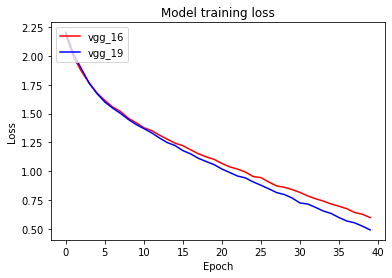

In [22]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

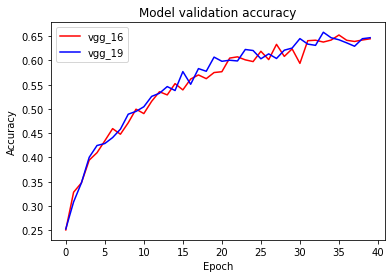

In [23]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()